#Initilization


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("praveengovi/coronahack-chest-xraydataset")

print("Path to dataset files:", path)

100%|██████████| 1.19G/1.19G [00:20<00:00, 62.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/praveengovi/coronahack-chest-xraydataset/versions/3


In [ ]:
import os

data_path = '/root/.cache/kagglehub/datasets/praveengovi/coronahack-chest-xraydataset/versions/3'
for root, dirs, files in os.walk(data_path):
    print("Directory:", root)
    for name in dirs:
        print(" - Subfolder:", name)
    for name in files[:5]:
        print(" - File:", name)
    break


Directory: /root/.cache/kagglehub/datasets/praveengovi/coronahack-chest-xraydataset/versions/3
 - Subfolder: Coronahack-Chest-XRay-Dataset
 - File: Chest_xray_Corona_dataset_Summary.csv
 - File: Chest_xray_Corona_Metadata.csv


In [ ]:
import pandas as pd

# Paths
base_path = '/root/.cache/kagglehub/datasets/praveengovi/coronahack-chest-xraydataset/versions/3'
img_dir = os.path.join(base_path, 'Coronahack-Chest-XRay-Dataset')
csv_path = os.path.join(base_path, 'Chest_xray_Corona_Metadata.csv')

# Load metadata
df = pd.read_csv(csv_path)
print("Total samples:", len(df))
df.head()


Total samples: 5910


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [ ]:
print(df['Label'].unique())

print(df['Label'].value_counts())




['Normal' 'Pnemonia']
Label
Pnemonia    4334
Normal      1576
Name: count, dtype: int64


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# for reference later

# Step 1: Paths
base_path = '/root/.cache/kagglehub/datasets/praveengovi/coronahack-chest-xraydataset/versions/3'
img_dir = os.path.join(base_path, 'Coronahack-Chest-XRay-Dataset')
csv_path = os.path.join(base_path, 'Chest_xray_Corona_Metadata.csv')

# Step 2: Load Metadata
df = pd.read_csv(csv_path)
print("Original label values:", df['Label'].unique())

# Step 3: Filter Only 'Normal' and 'Pnemonia'
df_filtered = df[df['Label'].isin(['Normal', 'Pnemonia'])].copy()
df_filtered['Label'] = df_filtered['Label'].map({'Normal': 0, 'Pnemonia': 1})

print("\nLabel distribution before image path assignment:")
print(df_filtered['Label'].value_counts())

# Step 4: Map All Image Files Recursively
all_image_paths = {}
for root, _, files in os.walk(img_dir):
    for f in files:
        all_image_paths[f] = os.path.join(root, f)

# Step 5: Assign Full Path to Each Row Based on Image Name
df_filtered['image_path'] = df_filtered['X_ray_image_name'].map(all_image_paths)

# Step 6: Remove Rows Without Found Image
before = len(df_filtered)
df_filtered = df_filtered[df_filtered['image_path'].notna()]
after = len(df_filtered)
print(f"\nRemoved {before - after} rows due to missing image files.")

print("\nFinal label distribution:")
print(df_filtered['Label'].value_counts())

# Step 7: Train/Test Split
if len(df_filtered) == 0:
    print("ERROR: Filtered dataset is empty. Please check label values or image paths.")
else:
    train_df, val_df = train_test_split(
        df_filtered,
        test_size=0.2,
        stratify=df_filtered['Label'],
        random_state=42
    )
    print(f"\n Train samples: {len(train_df)}")
    print(f" Validation samples: {len(val_df)}")


Original label values: ['Normal' 'Pnemonia']

Label distribution before image path assignment:
Label
1    4334
0    1576
Name: count, dtype: int64

Removed 0 rows due to missing image files.

Final label distribution:
Label
1    4334
0    1576
Name: count, dtype: int64

 Train samples: 4728
 Validation samples: 1182


In [ ]:
import numpy as np
from PIL import Image

IMG_SIZE = 128  # can be different if using untrained models

def load_images(df):
    images = []
    labels = []
    for _, row in df.iterrows():
        try:
            img = Image.open(row['image_path']).convert('L')  # Grayscale
            img = img.resize((IMG_SIZE, IMG_SIZE))
            img = np.array(img) / 255.0  # Normalize
            images.append(img)
            labels.append(row['Label'])
        except Exception as e:
            print(f"Error loading image {row['image_path']}: {e}")
            continue
    return np.array(images), np.array(labels)

# Load train/val images
X_train, y_train = load_images(train_df)
X_val, y_val = load_images(val_df)

# Reshape for CNN input (batch, height, width, channels)
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

print(" X_train shape:", X_train.shape)
print(" y_train shape:", y_train.shape)
print(" X_val shape:", X_val.shape)


 X_train shape: (4728, 128, 128, 1)
 y_train shape: (4728,)
 X_val shape: (1182, 128, 128, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt


# Standard Testing Parameter

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary output: Normal or Pneumonia
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary() # not needed, just nice to have a visualization of the data


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,705,345 (14.13 MB)

 Trainable params: 3,705,345 (14.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)


Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 113s 755ms/step - accuracy: 0.7243 - loss: 0.6368 - val_accuracy: 0.9036 - val_loss: 0.2983
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 134s 702ms/step - accuracy: 0.8977 - loss: 0.2913 - val_accuracy: 0.9298 - val_loss: 0.2047
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 109s 737ms/step - accuracy: 0.9112 - loss: 0.2290 - val_accuracy: 0.9408 - val_loss: 0.1742
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 108s 727ms/step - accuracy: 0.9284 - loss: 0.1911 - val_accuracy: 0.9425 - val_loss: 0.1730
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 142s 730ms/step - accuracy: 0.9428 - loss: 0.1684 - val_accuracy: 0.9442 - val_loss: 0.1564
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 140s 719ms/step - accuracy: 0.9485 - loss: 0.1440 - val_accuracy: 0.9484 - val_loss: 0.1630
Epoch 7/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 144s 736ms/step - accuracy: 0.9420 - loss: 0.1616 - val_accuracy: 0.9501 - val_loss: 0.1470
Epoch 8/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 137s 701ms/step - accuracy: 0.9568 -

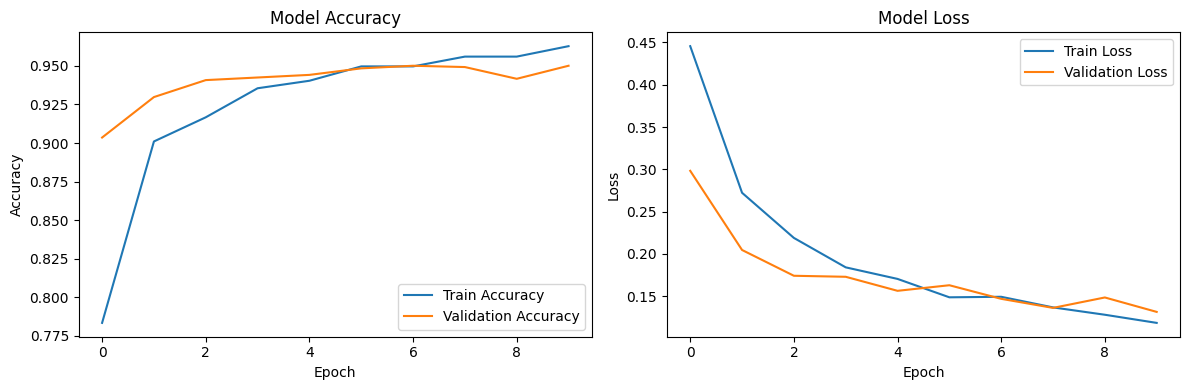

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


#experiment #1: reducing dense layer size from 64 to 32


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(32, activation='relu'),  # smaller than before. it was set to 64.
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)


Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 113s 740ms/step - accuracy: 0.9810 - loss: 0.0537 - val_accuracy: 0.9526 - val_loss: 0.1988
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 106s 717ms/step - accuracy: 0.9914 - loss: 0.0317 - val_accuracy: 0.9526 - val_loss: 0.1991
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 105s 709ms/step - accuracy: 0.9859 - loss: 0.0427 - val_accuracy: 0.9569 - val_loss: 0.2188
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 141s 706ms/step - accuracy: 0.9884 - loss: 0.0332 - val_accuracy: 0.9526 - val_loss: 0.2298
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 106s 714ms/step - accuracy: 0.9904 - loss: 0.0347 - val_accuracy: 0.9535 - val_loss: 0.1930
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 102s 693ms/step - accuracy: 0.9918 - loss: 0.0270 - val_accuracy: 0.9577 - val_loss: 0.2073
Epoch 7/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 144s 706ms/step - accuracy: 0.9930 - loss: 0.0238 - val_accuracy: 0.9585 - val_loss: 0.2503
Epoch 8/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 142s 710ms/step - accuracy: 0.9932 -

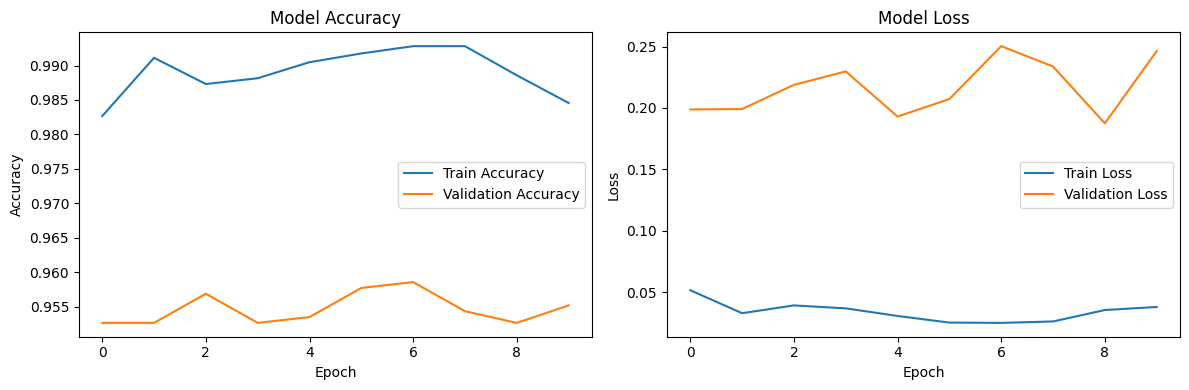

In [ ]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


#experiment #2: keeping dense at 32, dropout from 0.3 to 0.5


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)


Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 109s 725ms/step - accuracy: 0.7018 - loss: 0.5710 - val_accuracy: 0.9222 - val_loss: 0.3031
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 144s 741ms/step - accuracy: 0.8951 - loss: 0.2826 - val_accuracy: 0.9315 - val_loss: 0.2076
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 142s 741ms/step - accuracy: 0.9080 - loss: 0.2369 - val_accuracy: 0.9306 - val_loss: 0.2097
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 141s 736ms/step - accuracy: 0.9333 - loss: 0.2025 - val_accuracy: 0.9467 - val_loss: 0.1526
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 142s 736ms/step - accuracy: 0.9201 - loss: 0.2381 - val_accuracy: 0.9442 - val_loss: 0.1541
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 141s 729ms/step - accuracy: 0.9324 - loss: 0.2011 - val_accuracy: 0.9467 - val_loss: 0.1603
Epoch 7/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 143s 734ms/step - accuracy: 0.9405 - loss: 0.1912 - val_accuracy: 0.9484 - val_loss: 0.1477
Epoch 8/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 141s 728ms/step - accuracy: 0.9447 -

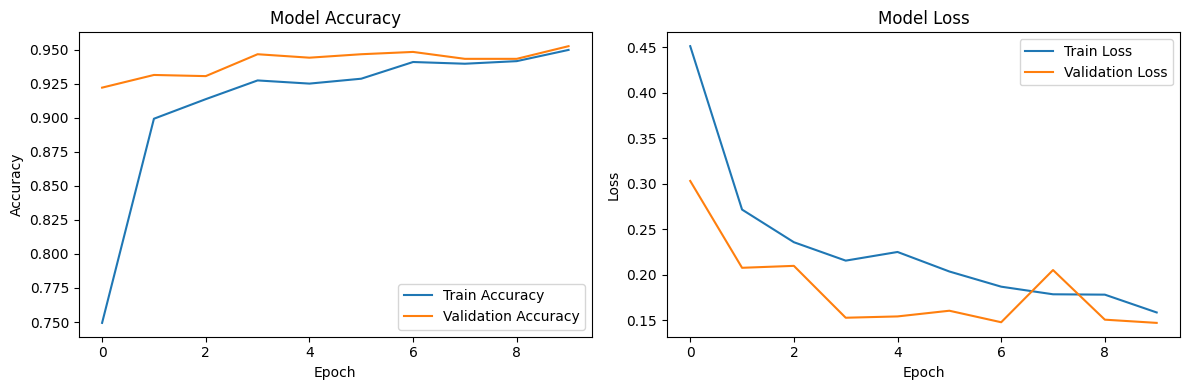

In [ ]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
